# Noise-As-Clean Experiment

[Europe PMC: Noisy-As-Clean: Learning Self-supervised Denoising from Corrupted Image](https://europepmc.org/article/med/32997627)

Key idea: 
- **Noise-As-CLean**: Using noisy image as both input and target
- **Generalization to Clean Images**: Even though trained with noisy images as target, the network, when presented with a real-world noisy image, generalizes to produce a denoised version, leveraging the structured noise learning.

Pros: 
1. **Simplicity**: There's no need for paired noisy-clean datasets. This can significantly simplify the data collection and pre-processing steps.
2. **Effectiveness**: In many scenarios, NAC has been found to perform comparably, or sometimes even better than traditional denoising methods, especially when there's a lack of ground-truth clean images.
3. **Robustness**: Training on various noise patterns might offer more robustness against different noise types.

Cons:
1. **Potential Overfitting**: If not implemented carefully, there's a risk that the network might overfit to the specific noise patterns of the training dataset, leading to less optimal performance on real-world or unseen noise distributions.
2. **Dependence on Noise Type**: The success of NAC might depend on the type and distribution of noise in the training data. It might not generalize well for all types of noises or for extremely high levels of noise.

In [1]:
import os
import copy
import json
import time

import numpy as np
import matplotlib.pyplot as plt

from module.utils import calculate_metrics, display_image_in_detail, plot_2d_data, timer_decorator, display_4d_image, timer_decorator
from module.datasets import load_4d_dicom, save_4d_dicom, restore_data

from module.models import UNet2_5D, ResNet34_UNet
from module.datasets import NACDataset
from module.loss import SSIMLoss, SSIM_MAELoss, SSIM_MSELoss

import h5py
from tqdm.notebook import tqdm


import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset

from torchsummary import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"device: {device}")

device: cuda:0


## Load preprocessed data

Noisy data...float32 (shape:(11, 24, 71, 192, 192); range:[0.0,1.0]; mean:0.4927044212818146); std:0.022372599691152573
{'original_min': -32768.0, 'original_max': 32767.0, 'z_score_mean': 201.4710693359375, 'z_score_std_dev': 1407.2664794921875, 'noise_min': -24.626427916933984, 'noise_max': 25.3497884510521}


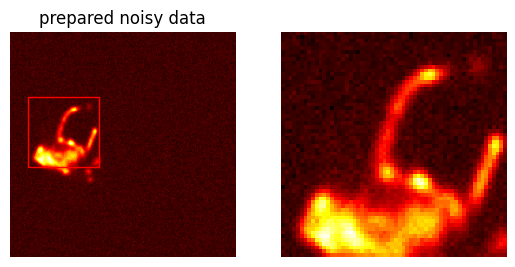

In [2]:
# load noisy data
with h5py.File('./dataset/preprocessed/PT_20p 150_120 OSEM_gaussian_0.50_batch.h5', 'r') as f:
    noisy_data = f['dataset'][...]
    restore_info = json.loads(f['restore_info'][()])
    
print(f"Noisy data...{noisy_data.dtype} (shape:{noisy_data.shape}; range:[{np.min(noisy_data)},{np.max(noisy_data)}]; mean:{np.mean(noisy_data)}); std:{np.std(noisy_data)}")

print(restore_info)

display_image_in_detail(noisy_data[0, 11, 38], title="prepared noisy data")

## Process Denoising

## 1. import denoising network

In [3]:
model = UNet2_5D(in_channels=3, out_channels=1)

#model = ResNet34_UNet(in_channels=3, out_channels=1)

model = model.to(device)
print("The number of parameters of the network is: ",  sum(p.numel() for p in model.parameters() if p.requires_grad))

summary(model, [(1, 192, 192), (1, 192, 192), (1, 192, 192)])

/root/miniconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


The number of parameters of the network is:  51096449
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 96, 96]           9,408
       BatchNorm2d-2           [-1, 64, 96, 96]             128
              ReLU-3           [-1, 64, 96, 96]               0
            Conv2d-4           [-1, 64, 96, 96]          36,864
       BatchNorm2d-5           [-1, 64, 96, 96]             128
              ReLU-6           [-1, 64, 96, 96]               0
            Conv2d-7           [-1, 64, 96, 96]          36,864
       BatchNorm2d-8           [-1, 64, 96, 96]             128
              ReLU-9           [-1, 64, 96, 96]               0
       BasicBlock-10           [-1, 64, 96, 96]               0
           Conv2d-11           [-1, 64, 96, 96]          36,864
      BatchNorm2d-12           [-1, 64, 96, 96]             128
             ReLU-13           [-1, 64, 96, 96]  

## 2. create NAC dataset and dataloader

In [4]:
# def split_tensor(data_tensor):
#     """split tensor into train, test, vali tensor

#     Args:
#         data_tensor (_type_): _description_

#     Returns:
#         _type_: _description_
#     """
#     test_tensor = data_tensor[0:1]
    
#     rest_tensor = data_tensor[1:]

#     total_samples = rest_tensor.shape[0]
    
#     train_ration = 0.8
#     train_length = int(train_ration * total_samples)
#     val_length = total_samples - train_length
    
    
#     train_subset, val_subset = random_split(rest_tensor, [train_length, val_length])
    
    
#     # Convert Subset back into tensors
#     train_tensor = train_subset.dataset[train_subset.indices]
#     val_tensor = val_subset.dataset[val_subset.indices]

#     return train_tensor, val_tensor, test_tensor


def split_data(data_array):
    """split ndarray into train, test, vali arrays

    Args:
        data_array (numpy.ndarray): The input data array.

    Returns:
        numpy.ndarray, numpy.ndarray, numpy.ndarray: Train, Validation, Test arrays.
    """
    test_array = data_array[0:1]
    rest_array = data_array[1:]

    total_samples = rest_array.shape[0]
    
    train_ration = 0.8
    train_length = int(train_ration * total_samples)
    val_length = total_samples - train_length
    
    indices = np.arange(total_samples)
    np.random.shuffle(indices)

    train_array = rest_array[indices[:train_length]]
    val_array = rest_array[indices[train_length:]]

    return train_array, val_array, test_array

In [5]:
## split ndarray data
train_data, val_data, test_data = split_data(noisy_data)


## add channel dim
train_tensor = torch.tensor(train_data[..., np.newaxis, :, :, :], dtype=torch.float32) 
val_tensor = torch.tensor(val_data[..., np.newaxis, :, :, :], dtype=torch.float32) 
test_tensor = torch.tensor(test_data[..., np.newaxis, :, :, :], dtype=torch.float32) 

print(f"train_tensor:\n {train_tensor.dtype}; shape:{train_tensor.shape}; range:({torch.min(train_tensor)},{torch.max(train_tensor)}); mean:{torch.mean(train_tensor)}; std:{torch.std(train_tensor)}")
print(f"val_tensor:\n {val_tensor.dtype}; shape:{val_tensor.shape}; range:({torch.min(val_tensor)},{torch.max(val_tensor)}); mean:{torch.mean(val_tensor)}; std:{torch.std(val_tensor)}")
print(f"test_tensor:\n {test_tensor.dtype}; shape:{test_tensor.shape}; range:({torch.min(test_tensor)},{torch.max(test_tensor)}); mean:{torch.mean(test_tensor)}; std:{torch.std(test_tensor)}")


## create dataset
train_dataset = NACDataset(train_tensor)
val_dataset = NACDataset(val_tensor)
test_dataset = NACDataset(test_tensor)

print(f"train_dataset: {len(train_dataset)}")
print(f"val_dataset: {len(val_dataset)}")
print(f"test_dataset: {len(test_dataset)}")


# create dataloader
batch_size = 32
num_workers = 12

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

train_tensor:
 torch.float32; shape:torch.Size([8, 24, 1, 71, 192, 192]); range:(0.0,0.9951097369194031); mean:0.49275830388069153; std:0.022342409938573837
val_tensor:
 torch.float32; shape:torch.Size([2, 24, 1, 71, 192, 192]); range:(0.008889039978384972,0.991707980632782); mean:0.4927845001220703; std:0.02245996706187725
test_tensor:
 torch.float32; shape:torch.Size([1, 24, 1, 71, 192, 192]); range:(0.002076786942780018,1.0); mean:0.4927551746368408; std:0.02243882790207863
train_dataset: 13248
val_dataset: 3312
test_dataset: 1656


Batch 1
top_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(0.9704879522323608,0.10312473773956299); mean:0.4918040633201599; std:0.018869681283831596
middle_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(0.9708611369132996,0.12722352147102356); mean:0.49177488684654236; std:0.01889204792678356
bottom_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(0.9809994697570801,0.19478614628314972); mean:0.491915762424469; std:0.019596945494413376
middle_target: torch.float32 torch.Size([32, 1, 192, 192]) range:(0.9708611369132996,0.12722352147102356); mean:0.49177488684654236; std:0.01889204792678356


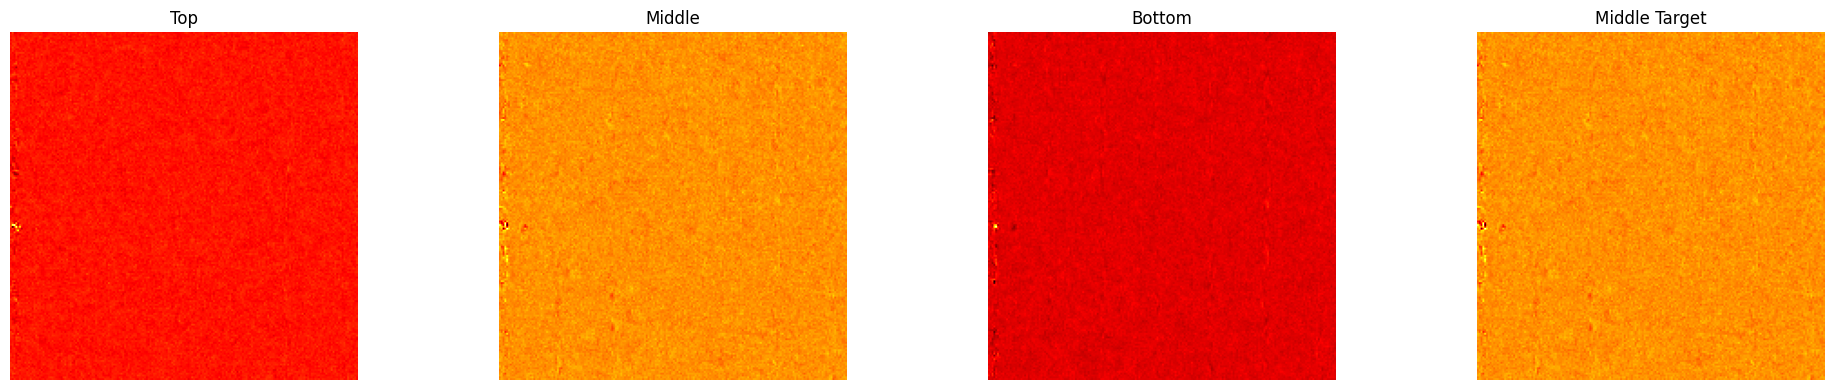

Batch 2
top_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(0.973679780960083,0.12900231778621674); mean:0.49300119280815125; std:0.020716529339551926
middle_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(0.9673187732696533,0.1982194185256958); mean:0.49333006143569946; std:0.02142414078116417
bottom_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(0.9778695106506348,0.12065771222114563); mean:0.4931507706642151; std:0.021095599979162216
middle_target: torch.float32 torch.Size([32, 1, 192, 192]) range:(0.9673187732696533,0.1982194185256958); mean:0.49333006143569946; std:0.02142414078116417


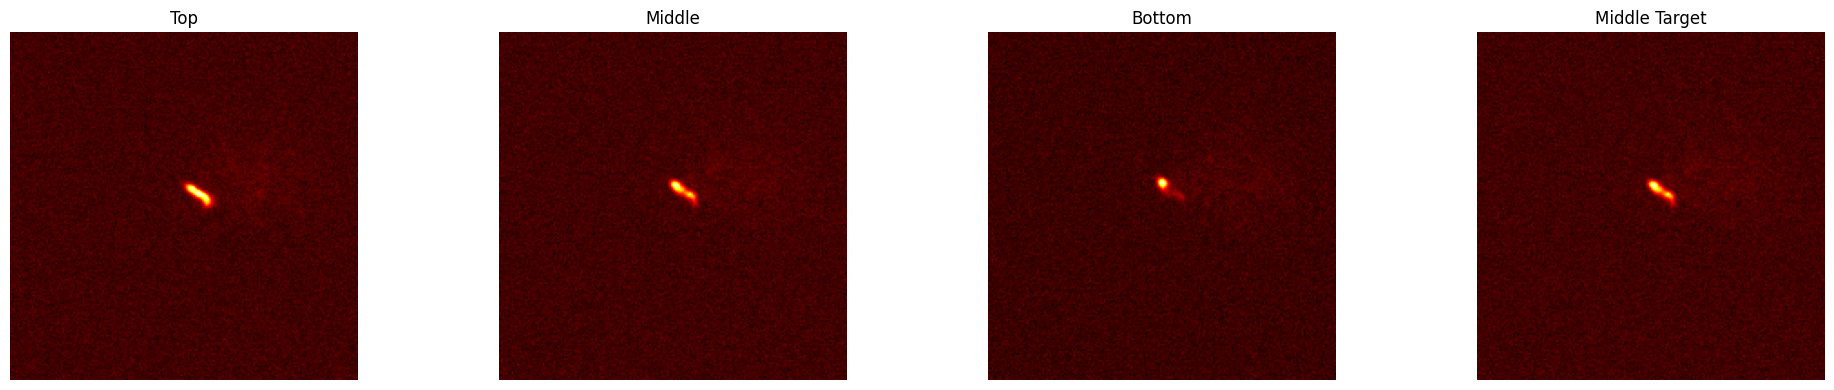

Batch 3
top_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(0.9735321402549744,0.048595331609249115); mean:0.4935324490070343; std:0.02479676529765129
middle_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(0.9825763702392578,0.23411348462104797); mean:0.493552565574646; std:0.024489542469382286
bottom_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(0.9707475304603577,0.1037881076335907); mean:0.4934328496456146; std:0.023499907925724983
middle_target: torch.float32 torch.Size([32, 1, 192, 192]) range:(0.9825763702392578,0.23411348462104797); mean:0.493552565574646; std:0.024489542469382286


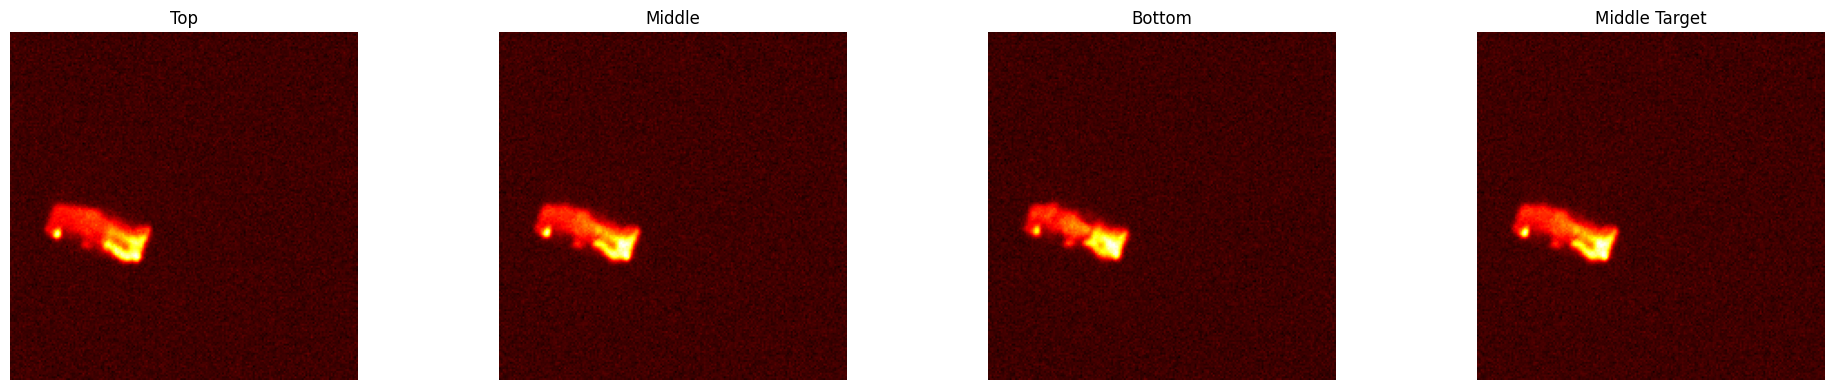

Batch 4
top_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(0.9750587344169617,0.13216203451156616); mean:0.4926925301551819; std:0.02124144695699215
middle_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(0.9746583104133606,0.12811534106731415); mean:0.49274852871894836; std:0.021924149245023727
bottom_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(0.9690482020378113,0.13057063519954681); mean:0.49266207218170166; std:0.02204541489481926
middle_target: torch.float32 torch.Size([32, 1, 192, 192]) range:(0.9746583104133606,0.12811534106731415); mean:0.49274852871894836; std:0.021924149245023727


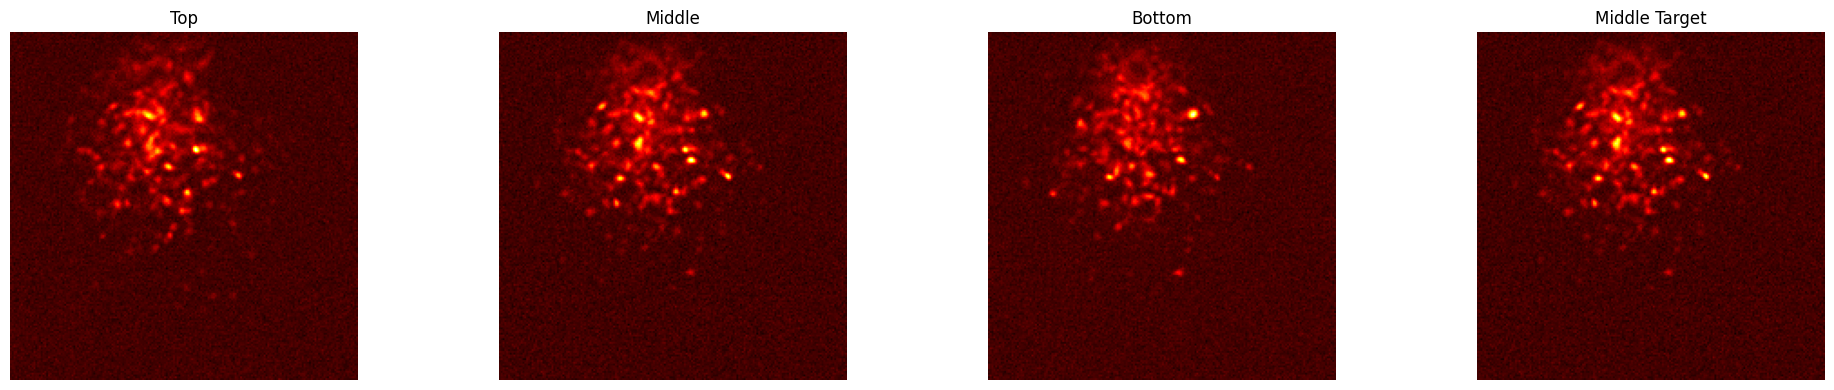

Batch 5
top_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(0.9791896939277649,0.04732657968997955); mean:0.4929083585739136; std:0.023132866248488426
middle_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(0.9751584529876709,0.05896065756678581); mean:0.49302637577056885; std:0.023422181606292725
bottom_slice: torch.float32 torch.Size([32, 1, 192, 192]) range:(0.9716174006462097,0.03401464223861694); mean:0.49296844005584717; std:0.02315422333776951
middle_target: torch.float32 torch.Size([32, 1, 192, 192]) range:(0.9751584529876709,0.05896065756678581); mean:0.49302637577056885; std:0.023422181606292725


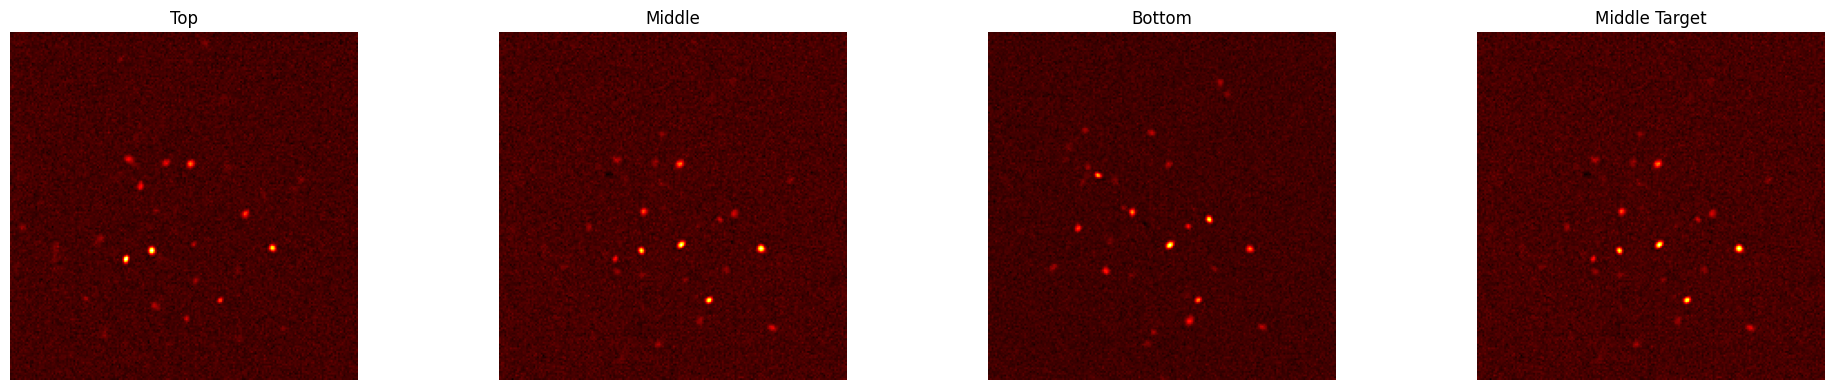

In [6]:
# example batch plot
num_batches_to_display = 5  # for example, show 3 batches

# Iterate through the DataLoader
for batch_idx, (top_slice, middle_slice, bottom_slice, middle_target) in enumerate(train_loader):
    
    # Print data details
    print(f"Batch {batch_idx + 1}")
    print(f"top_slice: {top_slice.dtype} {top_slice.shape} range:({torch.max(top_slice)},{torch.min(top_slice)}); mean:{torch.mean(top_slice)}; std:{torch.std(top_slice)}")
    print(f"middle_slice: {middle_slice.dtype} {middle_slice.shape} range:({torch.max(middle_slice)},{torch.min(middle_slice)}); mean:{torch.mean(middle_slice)}; std:{torch.std(middle_slice)}")
    print(f"bottom_slice: {bottom_slice.dtype} {bottom_slice.shape} range:({torch.max(bottom_slice)},{torch.min(bottom_slice)}); mean:{torch.mean(bottom_slice)}; std:{torch.std(bottom_slice)}")
    print(f"middle_target: {middle_target.dtype} {middle_target.shape} range:({torch.max(middle_target)},{torch.min(middle_target)}); mean:{torch.mean(middle_target)}; std:{torch.std(middle_target)}")

    # select the show baych index
    idx = -1

    fig, axes = plt.subplots(1, 4, figsize=(20, 4))

    axes[0].imshow(top_slice[idx].squeeze().numpy(), cmap='hot')
    axes[0].set_title('Top')

    axes[1].imshow(middle_slice[idx].squeeze().numpy(), cmap='hot')
    axes[1].set_title('Middle')

    axes[2].imshow(bottom_slice[idx].squeeze().numpy(), cmap='hot')
    axes[2].set_title('Bottom')

    axes[3].imshow(middle_target[idx].squeeze().numpy(), cmap='hot')
    axes[3].set_title('Middle Target')

    
    for ax in axes:
        ax.axis('off')

    plt.tight_layout()
    plt.show()
    
    # Break loop after displaying desired number of batches
    if batch_idx + 1 == num_batches_to_display:
        break


## 3.  define training modules 

In [7]:
def train(model, train_loader, criterion, optimizer, scheduler, device):
    model.train()
    total_loss = 0.0
    pbar = tqdm(train_loader, desc="Training", dynamic_ncols=True)
    for top_slice, middle_slice, bottom_slice, middle_target in pbar:
        
        top_slice, middle_slice, bottom_slice, middle_target = top_slice.to(device), middle_slice.to(device), bottom_slice.to(device), middle_target.to(device)
        
        # Forward
        outputs = model(top_slice, middle_slice, bottom_slice)
        
        # Zero the gradient buffers
        optimizer.zero_grad()
        
        loss = criterion(outputs, middle_target)
        
        # Backward
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        total_loss += loss.item()
        pbar.set_postfix({"batch_loss": loss.item()})
    
    scheduler.step()
    avg_loss = total_loss / len(train_loader)
    return avg_loss



def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0.0 
    pbar = tqdm(val_loader, desc="Validating", dynamic_ncols=True)
    with torch.no_grad():
        for top_slice, middle_slice, bottom_slice, middle_target in pbar:
            
            top_slice, middle_slice, bottom_slice, middle_target = top_slice.to(device), middle_slice.to(device), bottom_slice.to(device), middle_target.to(device)
            
            outputs = model(top_slice, middle_slice, bottom_slice)
            
            loss = criterion(outputs, middle_target)
            total_loss += loss.item()
            pbar.set_postfix({"batch_loss": loss.item()})
    
    avg_loss = total_loss / len(val_loader)
    
    return avg_loss

# @timer_decorator
# def test(model, test_loader, device):
#     model.eval()
#     preds = []
#     targets = []
#     pbar = tqdm(test_loader, desc="Testing", dynamic_ncols=True)
#     with torch.no_grad():
#         for top_slice, mask_middle_slice, bottom_slice, middle_slice in pbar:
#             top_slice, mask_middle_slice, bottom_slice, middle_slice = top_slice.to(device), mask_middle_slice.to(device), bottom_slice.to(device), middle_slice.to(device)
            
#             pred = model(top_slice, mask_middle_slice, bottom_slice)
#             preds.append(pred.cpu()) # predict
#             targets.append(middle_slice.cpu()) # original input data
            
#     return preds, targets
# def test(model, test_loader, device, original_shape):
#     # 初始化两个全0的tensor用于存放预测和目标
#     preds = torch.zeros(original_shape).to(device)
#     targets = torch.zeros(original_shape).to(device)

#     model.eval()
#     pbar = tqdm(test_loader, desc="Testing", dynamic_ncols=True)
#     with torch.no_grad():
#         for idx, (top_slice, mask_middle_slice, bottom_slice, middle_slices) in enumerate(pbar):
#             top_slice, mask_middle_slice, bottom_slice, middle_slices = top_slice.to(device), mask_middle_slice.to(device), bottom_slice.to(device), middle_slices.to(device)
            
#             batch_preds = model(top_slice, mask_middle_slice, bottom_slice)
            
#             for b_idx, pred in enumerate(batch_preds):
#                 # 计算应该放置预测值和目标值的位置
#                 patience_idx = (idx * len(batch_preds) + b_idx) // (original_shape[1] * (original_shape[3] - 2))
#                 time_idx = ((idx * len(batch_preds) + b_idx) % (original_shape[1] * (original_shape[3] - 2))) // (original_shape[3] - 2)
#                 depth_idx = (idx * len(batch_preds) + b_idx) % (original_shape[3] - 2) + 1
                
#                 pred = pred.squeeze(0)
#                 middle_slice = middle_slices[b_idx].squeeze(0)
                
#                 preds[patience_idx, time_idx, :, depth_idx, :, :] = pred
#                 targets[patience_idx, time_idx, :, depth_idx, :, :] = middle_slice

#     return preds.cpu(), targets.cpu()

def test(model, test_loader, device, dataset):
    model.eval()
    p, t, d = dataset.p, dataset.t, dataset.d
    # Note: d represents number of continuous slices after subtracting 2
    original_shape = (p, t, dataset.data_tensor.shape[2], d+2, dataset.data_tensor.shape[4], dataset.data_tensor.shape[5])

    preds = torch.zeros(original_shape).to(device)
    targets = torch.zeros(original_shape).to(device)

    pbar = tqdm(test_loader, desc="Testing", dynamic_ncols=True)
    with torch.no_grad():
        for idx, (top_slice, middle_slice, bottom_slice, middle_target) in enumerate(pbar):
            
            top_slice, middle_slice, bottom_slice, middle_target = top_slice.to(device), middle_slice.to(device), bottom_slice.to(device), middle_target.to(device)
            
            batch_preds = model(top_slice, middle_slice, bottom_slice)

            for b_idx, pred in enumerate(batch_preds):
                pred = pred.squeeze(0) # [channels, height, width]
                true_idx = idx*test_loader.batch_size + b_idx
                patience_idx = true_idx // (t * d)
                time_idx = (true_idx % (t * d)) // d
                depth_idx = true_idx % d + 1

                preds[patience_idx, time_idx, :, depth_idx, :, :] = pred
                targets[patience_idx, time_idx, :, depth_idx, :, :] = middle_target[b_idx]

    return preds.cpu(), targets.cpu()




@timer_decorator
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=50, patience=5, save_path='path/to/your/directory'):
    best_loss = float('inf')
    early_stopping_counter = 0
    best_epoch = -1
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        train_loss = train(model, train_loader, criterion, optimizer, scheduler, device)
        val_loss = validate(model, val_loader, criterion, device)
        
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.8f}, Validation Loss: {val_loss:.8f}, LR: {current_lr:.8e}")

        # Save the model with the best validation loss
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            best_epoch = epoch + 1  # 1-based counting for epoch
            best_save_path = os.path.join(save_path, f'best_model.pth')
            torch.save(best_model_wts, best_save_path)
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f"Early stopping after {patience} epochs without improvement epoch:{epoch - patience}.")
                break

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [8]:
# define loss, optimizer, lr_scheduler

criterion = nn.L1Loss()
#criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=1e-3)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

## 4. process training

In [9]:
trained_model = train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=200, patience=10, save_path="./check_points")

Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 1/200, Train Loss: 0.01264779, Validation Loss: 0.00959332, LR: 1.00000000e-03


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 2/200, Train Loss: 0.00442947, Validation Loss: 0.00933069, LR: 1.00000000e-03


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 3/200, Train Loss: 0.00363776, Validation Loss: 0.01115024, LR: 1.00000000e-03


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 4/200, Train Loss: 0.00312527, Validation Loss: 0.00671915, LR: 1.00000000e-03


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 5/200, Train Loss: 0.00277165, Validation Loss: 0.00879910, LR: 5.00000000e-04


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 6/200, Train Loss: 0.00221928, Validation Loss: 0.00278926, LR: 5.00000000e-04


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 7/200, Train Loss: 0.00201906, Validation Loss: 0.00296715, LR: 5.00000000e-04


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 8/200, Train Loss: 0.00170293, Validation Loss: 0.00152020, LR: 5.00000000e-04


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 9/200, Train Loss: 0.00146549, Validation Loss: 0.00234890, LR: 5.00000000e-04


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 10/200, Train Loss: 0.00147223, Validation Loss: 0.00324750, LR: 2.50000000e-04


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 11/200, Train Loss: 0.00091525, Validation Loss: 0.00213317, LR: 2.50000000e-04


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 12/200, Train Loss: 0.00101907, Validation Loss: 0.00248181, LR: 2.50000000e-04


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 13/200, Train Loss: 0.00099450, Validation Loss: 0.00162520, LR: 2.50000000e-04


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 14/200, Train Loss: 0.00080971, Validation Loss: 0.00247530, LR: 2.50000000e-04


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 15/200, Train Loss: 0.00120216, Validation Loss: 0.00149700, LR: 1.25000000e-04


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 16/200, Train Loss: 0.00071047, Validation Loss: 0.00093756, LR: 1.25000000e-04


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 17/200, Train Loss: 0.00066033, Validation Loss: 0.00105562, LR: 1.25000000e-04


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 18/200, Train Loss: 0.00060694, Validation Loss: 0.00099118, LR: 1.25000000e-04


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 19/200, Train Loss: 0.00061567, Validation Loss: 0.00093461, LR: 1.25000000e-04


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 20/200, Train Loss: 0.00056481, Validation Loss: 0.00079377, LR: 6.25000000e-05


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 21/200, Train Loss: 0.00047987, Validation Loss: 0.00081723, LR: 6.25000000e-05


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 22/200, Train Loss: 0.00046972, Validation Loss: 0.00089063, LR: 6.25000000e-05


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 23/200, Train Loss: 0.00044752, Validation Loss: 0.00049222, LR: 6.25000000e-05


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 24/200, Train Loss: 0.00046204, Validation Loss: 0.00092976, LR: 6.25000000e-05


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 25/200, Train Loss: 0.00045843, Validation Loss: 0.00049534, LR: 3.12500000e-05


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 26/200, Train Loss: 0.00038936, Validation Loss: 0.00066067, LR: 3.12500000e-05


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 27/200, Train Loss: 0.00040114, Validation Loss: 0.00062316, LR: 3.12500000e-05


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 28/200, Train Loss: 0.00039636, Validation Loss: 0.00040708, LR: 3.12500000e-05


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 29/200, Train Loss: 0.00038032, Validation Loss: 0.00041259, LR: 3.12500000e-05


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 30/200, Train Loss: 0.00038243, Validation Loss: 0.00046169, LR: 1.56250000e-05


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 31/200, Train Loss: 0.00034795, Validation Loss: 0.00046446, LR: 1.56250000e-05


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 32/200, Train Loss: 0.00035790, Validation Loss: 0.00045271, LR: 1.56250000e-05


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 33/200, Train Loss: 0.00034957, Validation Loss: 0.00036666, LR: 1.56250000e-05


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 34/200, Train Loss: 0.00034609, Validation Loss: 0.00039612, LR: 1.56250000e-05


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 35/200, Train Loss: 0.00035286, Validation Loss: 0.00059481, LR: 7.81250000e-06


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 36/200, Train Loss: 0.00033157, Validation Loss: 0.00036842, LR: 7.81250000e-06


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 37/200, Train Loss: 0.00033181, Validation Loss: 0.00034118, LR: 7.81250000e-06


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 38/200, Train Loss: 0.00032533, Validation Loss: 0.00034594, LR: 7.81250000e-06


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 39/200, Train Loss: 0.00032483, Validation Loss: 0.00038001, LR: 7.81250000e-06


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 40/200, Train Loss: 0.00032675, Validation Loss: 0.00033956, LR: 3.90625000e-06


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 41/200, Train Loss: 0.00032106, Validation Loss: 0.00044369, LR: 3.90625000e-06


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 42/200, Train Loss: 0.00031580, Validation Loss: 0.00031719, LR: 3.90625000e-06


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 43/200, Train Loss: 0.00031581, Validation Loss: 0.00032309, LR: 3.90625000e-06


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 44/200, Train Loss: 0.00031545, Validation Loss: 0.00030686, LR: 3.90625000e-06


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 45/200, Train Loss: 0.00031300, Validation Loss: 0.00034295, LR: 1.95312500e-06


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 46/200, Train Loss: 0.00030834, Validation Loss: 0.00030565, LR: 1.95312500e-06


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 47/200, Train Loss: 0.00030893, Validation Loss: 0.00033288, LR: 1.95312500e-06


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 48/200, Train Loss: 0.00030770, Validation Loss: 0.00032776, LR: 1.95312500e-06


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 49/200, Train Loss: 0.00030745, Validation Loss: 0.00035579, LR: 1.95312500e-06


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 50/200, Train Loss: 0.00031008, Validation Loss: 0.00030975, LR: 9.76562500e-07


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 51/200, Train Loss: 0.00030434, Validation Loss: 0.00032522, LR: 9.76562500e-07


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 52/200, Train Loss: 0.00030424, Validation Loss: 0.00029708, LR: 9.76562500e-07


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 53/200, Train Loss: 0.00030390, Validation Loss: 0.00030894, LR: 9.76562500e-07


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 54/200, Train Loss: 0.00030379, Validation Loss: 0.00030275, LR: 9.76562500e-07


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 55/200, Train Loss: 0.00030281, Validation Loss: 0.00030899, LR: 4.88281250e-07


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 56/200, Train Loss: 0.00030161, Validation Loss: 0.00029803, LR: 4.88281250e-07


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 57/200, Train Loss: 0.00030291, Validation Loss: 0.00030252, LR: 4.88281250e-07


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 58/200, Train Loss: 0.00030268, Validation Loss: 0.00032970, LR: 4.88281250e-07


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 59/200, Train Loss: 0.00030240, Validation Loss: 0.00030705, LR: 4.88281250e-07


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 60/200, Train Loss: 0.00030305, Validation Loss: 0.00030850, LR: 2.44140625e-07


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 61/200, Train Loss: 0.00030185, Validation Loss: 0.00031784, LR: 2.44140625e-07


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Validating:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 62/200, Train Loss: 0.00030177, Validation Loss: 0.00032088, LR: 2.44140625e-07
Early stopping after 10 epochs without improvement epoch:51.
train_and_evaluate running: 17833.88751721196 second


## 5. process denoising

In [10]:
# load best model
model.load_state_dict(torch.load('check_points/best_model.pth'))


<All keys matched successfully>

In [11]:
# denoising 
preds, targets = test(model, test_loader, device, test_dataset)

Testing:   0%|          | 0/52 [00:00<?, ?it/s]

denoised data: float32; shape:(24, 71, 192, 192); range:(0.0,1.0478579998016357); mean:0.4789160192012787; std:0.08452559262514114
true_data data: float32; shape:(24, 71, 192, 192); range:(0.0,1.0); mean:0.47894221544265747; std:0.08453914523124695
data range: 0.5109070539474487
calculate_metrics running: 0.04351204261183739 second
PSNR: 56.03603767400182; SSIM: 0.9997083378008355; MAE: 0.0003091250255238265; BRISQUE: 31.597763259022116


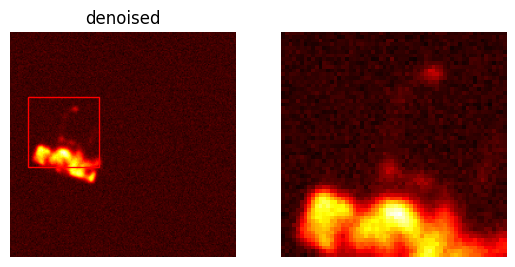

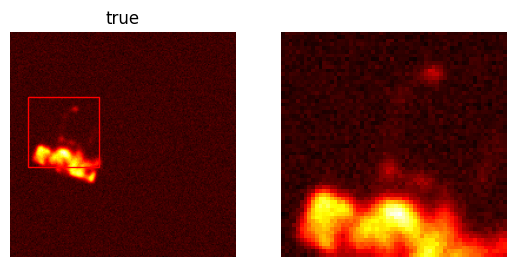

In [15]:
denoised_data = preds[0].squeeze(1).numpy()
true_data = targets[0].squeeze(1).numpy()

print(f"denoised data: {denoised_data.dtype}; shape:{denoised_data.shape}; range:({np.min(denoised_data)},{np.max(denoised_data)}); mean:{np.mean(denoised_data)}; std:{np.std(denoised_data)}")
print(f"true_data data: {true_data.dtype}; shape:{true_data.shape}; range:({np.min(true_data)},{np.max(true_data)}); mean:{np.mean(true_data)}; std:{np.std(true_data)}")


# example plot
data_range_true = np.max(true_data[11, 38]) - np.min(true_data[11, 38])
data_range_denoised = np.max(denoised_data[11, 38]) - np.min(denoised_data[11, 38])
data_range = max(data_range_true, data_range_denoised)
print(f"data range: {data_range}")
psnr_values, ssim_values, mae_values, brisque_values = calculate_metrics(denoised_data[11, 38], true_data[11, 38], data_range=data_range)
print(f"PSNR: {np.nanmean(psnr_values)}; SSIM: {np.nanmean(ssim_values)}; MAE: {np.sum(mae_values)}; BRISQUE: {np.mean(brisque_values)}")

display_image_in_detail(denoised_data[15, 38], title='denoised')
display_image_in_detail(true_data[15, 38], title='true')

## 6. metrics evaluation

In [13]:
data_range_true = np.max(true_data) - np.min(true_data)
data_range_denoised = np.max(denoised_data) - np.min(denoised_data)
data_range = max(data_range_true, data_range_denoised)
print(f"data range: {data_range}")

#
psnr_values, ssim_values, mae_values, brisque_values = calculate_metrics(denoised_data, true_data, data_range=data_range)

psnr_values[np.isinf(psnr_values)] = np.nan # set inf value to nan

print(f"PSNR: {np.nanmean(psnr_values)}; SSIM: {np.nanmean(ssim_values)}; MAE: {np.sum(mae_values)}; BRISQUE: {np.nanmean(brisque_values)}")

data range: 1.0478579998016357


/root/miniconda3/lib/python3.8/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range ** 2) / err)
/root/miniconda3/lib/python3.8/site-packages/brisque/brisque.py:113: RuntimeWarning: invalid value encountered in scalar divide
  return (np.sum(np.abs(x)) / size) ** 2 / (np.sum(x ** 2) / size)
/root/miniconda3/lib/python3.8/site-packages/brisque/brisque.py:123: RuntimeWarning: invalid value encountered in divide
  return squares_sum / ((filtered_values.shape))


calculate_metrics running: 50.07253620773554 second
PSNR: 62.63210813109686; SSIM: 0.9997934364639497; MAE: 0.4744313321862137; BRISQUE: 32.77104371008201


# Save denormalized denoised data into 16-bit DICOM files

In [16]:
# denormalized denoised data
restored_data = restore_data(denoised_data, restore_info)
print(f"restore_data: {restored_data.dtype} shape:{restored_data.shape}; range:({np.min(restored_data)},{np.max(restored_data)}); mean:{np.mean(restored_data)}; std:{np.std(restored_data)}")
display_4d_image(restored_data)

restore_data: int16 shape:(24, 71, 192, 192); range:(-32768,32767); mean:-725.0078654639971; std:5675.853115087015


interactive(children=(IntSlider(value=0, description='Time', max=23), IntSlider(value=0, description='Slice', …

In [17]:
# save denormalized denoised data as 16-bit gray-scale .DICOM files
origin_dicom_folder = './dataset/10_05_2021_PET_only/PT_20p 150_120 OSEM'

output_folder = './dataset/denoised/NAC/PT_20p 150_120 OSEM_gaussian_0.50_batch_resnet34unet'

save_4d_dicom(origin_dicom_folder, restored_data, output_folder)

Processing time points: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]

Saved 1704 denoised DICOM files.
